# Percepción Computacional
## Actividad 2: Segmentación

* __Juan Julio González Paredes__
* __Panagiotis Mourtis Ioannou__
* __Jordi Linares__
* __Ivan Jesus Zepeda Gonzalez__


__Objetivos__

En esta actividad se requiere segmentar los patos de la imagen proporcionada, llegando al resultado esperado, totalmente binaria, consistente de 0 y 1 (True/False), llegando a ignorar el fondo.

In [1]:
# Cargar las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt

from skimage.color import rgb2gray, label2rgb
from skimage import data
from skimage.filters import gaussian, sobel, threshold_otsu
from skimage.color import rgb2gray
from skimage.segmentation import (active_contour, felzenszwalb, quickshift, 
                                 mark_boundaries, slic, clear_border)

from skimage.future.graph import rag_mean_color, cut_normalized
import io

from itertools import product

## Descripción
Se ha elegido realizar la actividad utilizando distintas técnicas de segmentación. Como se sugiere, se ha tomado ventaja del color de la imagen. Se ha realizado un tratamiento previo de la imagen para continuar con la segmentación.

### FUNCIONES
Se presentan dos funciones otorgadas previamente.
* __imshow(img)__. Que simplemente genera un subplot para mostrar la figura que recibe ya con un formato estandar en toda la practica.
* __factor_f_evaluacion(binary_image, ground_truth)__. Que ayuda comparar cómo de buena es una determinada segmentación en comparación con el ground truth. Ambas imagenes deben contener valores True/False.

In [2]:
# Defino una función para mostrar una imagen por pantalla con el criterio que considero más acertado
def imshow(img):
    fig, ax = plt.subplots(figsize=(8, 8))
    # El comando que realmente muestra la imagen
    ax.imshow(img,cmap=plt.cm.gray)
    # Para evitar que aparezcan los números en los ejes
    ax.set_xticks([]), ax.set_yticks([])
    plt.show()

In [3]:
# Función para comparar cómo de buena es una determinada segmentación en comparación con el ground truth
# Ambas imagenes deben contener valores True/False
def factor_f_evaluation(binary_image, ground_truth):
    TP = np.sum(np.logical_and(binary_image, ground_truth))
    TN = np.sum(np.logical_and(np.logical_not(binary_image), np.logical_not(ground_truth)))
    FP = np.sum(np.logical_and(np.logical_not(binary_image), ground_truth))
    FN = np.sum(np.logical_and(binary_image, np.logical_not(ground_truth)))
    P = TP/np.float(TP+FP)
    R = TP/np.float(TP+FN)
    if P+R == 0:
        F = 0
    else:
        F = 2*P*R/(P+R)
    return F

## CARGA DE IMAGEN

Se usan las imagenes proporcionadas de Uni-Freiburg [https://lmb.informatik.uni-freiburg.de/resources/datasets/moseg.en.html].
Se puede utilizar formato "PNG", "JPG" y "PPM"

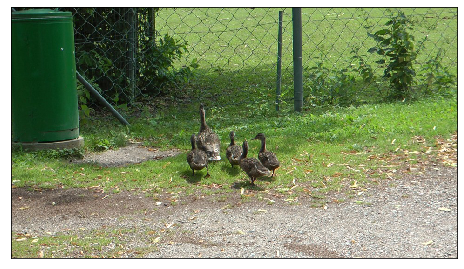

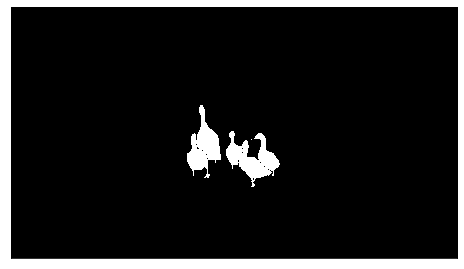

In [4]:
# https://lmb.informatik.uni-freiburg.de/resources/datasets/moseg.en.html
patos = data.imread('ducks01_0100.jpg')
#gt_patos = rgb2gray(data.imread('ducks01_0100_gt.png'))<1
gt_patos = rgb2gray(data.imread('ducks01_0100_gt.ppm'))<1
imshow(patos)
imshow(gt_patos)

## TRATAMIENTO PREVIO

Se realiza una copia de la imagen original, y se realiza un filtro de ruido impulsivo por la media de n pixeles.

In [5]:
def impulsiveNoiseFilter (I, v):
    # I: numpy array, imagen a tratar
    # v: int, tamaño en pixeles de la ventana cuadrada
        
    # Aseguramos que la ventana tiene dimensiones impares 
    if v%2 == 0:
        v+=1
        
    # Obtenemos las dimensiones de la imagen - Vamos a suponer que siempre será RGB
    x_dim = I.shape[0]
    y_dim = I.shape[1]
    
    # Recorremos la imagen   
    for x in range(x_dim):
        for y in range(y_dim):
            for s in range(3):
                I[x,y,s] =np.median(I[x:x+v, y:y+v,s])
                
    # Devolvemos la imagen tratada
    return (I)    

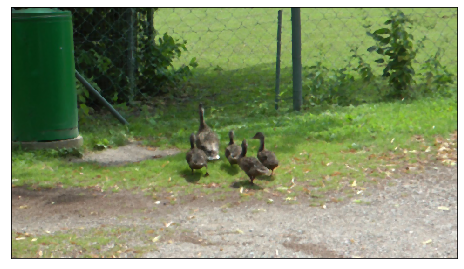

In [6]:
# Realizamos una copia de la imagen a tratar y mantener tambien la original
patos_filtrados = np.copy(patos)
# Llamamos a la función para eleminar el ruido
patos_filtrados = impulsiveNoiseFilter(patos_filtrados, 5)
imshow(patos_filtrados)

Realizamos una copia de la imagen anterior para poder mantener 
y comparar el resultado 
del tratamiento y la original

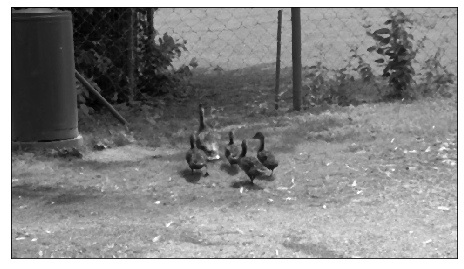

In [7]:
patos_gris = np.copy(patos_filtrados)
patos_gris = rgb2gray(patos_gris)
# Viasualizamos la imagen en Blanco y Negro
imshow(patos_gris)

El primer paso de la segmentacion se usa __slic__ para seccionar por kfolds partes de la imagen.

Posteriormente se usa el filtro __sobel__ para encontrar bordes en la imagen y mostrarlo en alto contraste (blanco y negro).

La imagen para continuar trabajandola es la previa a sobel.

/Users/ivan/anaconda3/envs/MIA/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


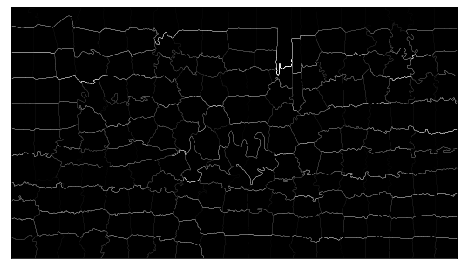

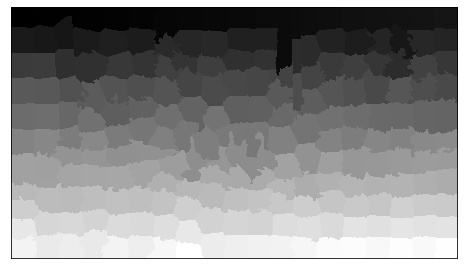

In [8]:
img = np.copy(patos_filtrados)
labels = slic(img, compactness=30, n_segments=200)
imshow(sobel(labels))
imshow(labels)

Se muestra la misma imagen procesada con un degradado de tipo HSV (Hue, Saturation, Value).

Con este degradado se logra separar a los patos en una tonalidad del resto de la imagen.

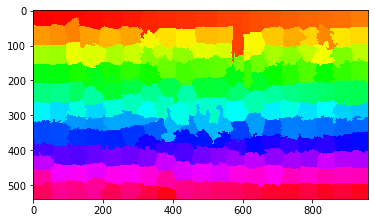

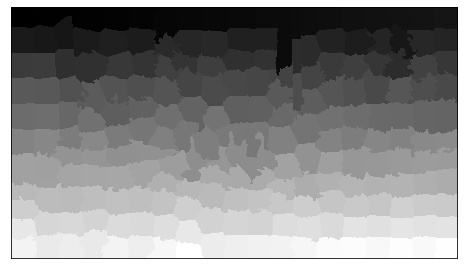

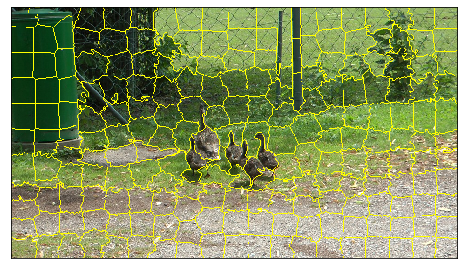

In [9]:
plt.imshow(labels,cmap = 'hsv')
labelsgray = rgb2gray(labels)
imshow(labelsgray)
boundaries=mark_boundaries(patos,labels)
imshow(boundaries)

## Segmentación por color

Para una segmentacion de color, se hace una funcion que reciba la imagen y una lista de coordenadas de la imagen.

Sí coincide esta lista se asigna valor 1, si esta fuera de esta pone 0. Asi obtenemos una imagen blanco y negro, 
seccionando previamente partes de la imagen que no necesitamos.

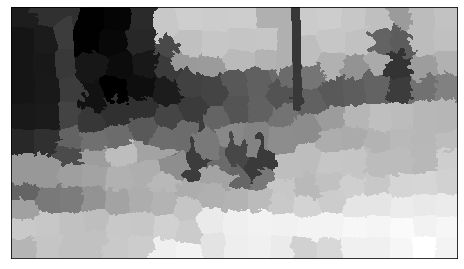

In [10]:
#imshow(labels) # Vemos claramente en el centro 2 áreas donde están los patos (más perfilados el grupo de la derecha)
from skimage import segmentation, color

out1 = color.label2rgb(labels, patos_gris, kind='avg')
imshow(out1)

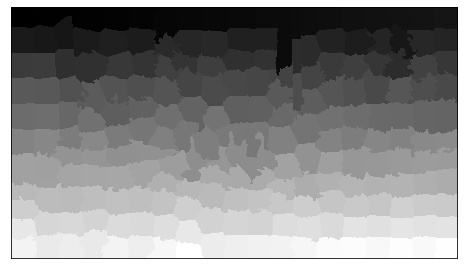

In [11]:
imshow(labels) # Vemos claramente en el centro 2 áreas donde están los patos (más perfilados el grupo de la derecha)

In [12]:
def segmentacion_por_color(img, colors):
    """Generamos una imagen binaria con sólo los colores de la lista colors"""
    rows = img.shape[0]
    cols = img.shape[1]
    
    result = np.copy(img)
    
    for x in range(0, rows):
        for y in range(0, cols):
            if (labels[x, y] in colors):
                result[x, y] = 1
            else:
                result[x, y] = 0
    return result

In [13]:
result = segmentacion_por_color(labels, [labels[320, 400], [labels[340, 500]], [labels[320, 440]],[labels[340, 540]]]) # Coordenadas de los 2 grupos de patos

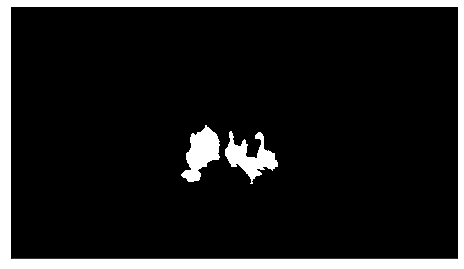

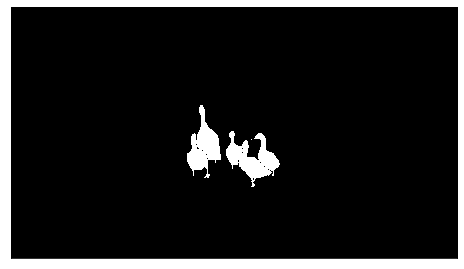

In [14]:
imshow(result)
imshow(gt_patos)

In [15]:
print(factor_f_evaluation(result, gt_patos))

0.8530320416629887


# Resultado esperado

Resultado de la segmentacion

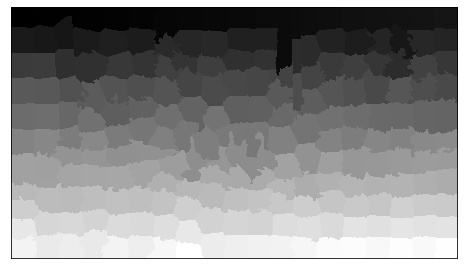

In [16]:
imshow(labels)

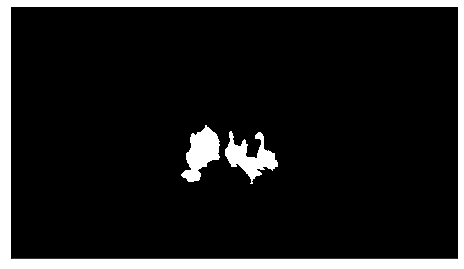

In [17]:
imshow(result)

# Conclusiones

__Nota__: El proceso hasta ahora presentado, fue el que resulto con mejor evaluacion. se omitio presentar la comparacion al inicio para evitar confusion.

Haciendo un analisis de __result__ en la funcion_f_evaluation, se obtiene un puntaje de 0.8530320416629887
siendo gran parte semejante al ground truth.
Se hizo uso de distintas tecnicas, pero ninguna se acercaba al resultado esperado.  La forma de recorte quedaba muy sucia, o distinta al objetivo.
Este es un metodo semisupervisado. El sobel es similar al active_contours que selecciona partes, pero este funciona muy bien si el objeto esta muy aislado del fondo. En este caso, con el fondo tan variable el contour, no se pega bien al objetivo.
El mejor approach fue segmentar con slic, y usar los tonos de grises mostrados en los patos, y recortar por medio de una mascara, donde si councide la tonalidad del pixel analizado a la muestras enviadas lo convierte a binario True, si no coincide lo deja en False.

Comparando con otras tecnicas, este fue el proceso con un resultado mas limpio, menos intervencion, y con una evaluacion mas alta.
El proceso que sigue en mejor evaluacion fue el de Contorno Morfologico GAC (evolucion) que se muestra mas adelante.




## Practica Grupal

* Todos los miembros se han integrado al trabajo del grupo
 - Si
 
* Todos los miembros participan activamente
 - Si
 
* Todos los miembros respetan otras ideas aportadas
 - Si
 
* Todos los miembros participan en la elaboración del informe
 - Si
 
* Me he preocupado por realizar un trabajo cooperativo con mis compañeros
 - Si
 
* Señala si consideras que algún aspecto del trabajo en grupo no ha sido adecuado


## Otras técnicas y comparacion entre estas

Aqui se presentan los intentos de metodos que sus resultados estuvieron mas lejanos al objetivo final.
Algunos estan mas elaborados, pues se encontro cierta posibilidad de un gran resultado, mientras otros, se descartaron desde los primeros resultados.
Otras tecnicas fallidas que no se muestran son: por bordes, histograma y llenado de agujeros.

In [18]:
import cv2
import imageio
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import data
from skimage import feature
from skimage import img_as_float
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte
from skimage.feature import greycomatrix
from skimage.filters import rank
from skimage.filters import median
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)
from skimage.exposure import histogram
from skimage.morphology import disk
from skimage.morphology import watershed

Carga de imagen y pre procesamiento de esta.
Estas variables se usaran en el resto de las celdas

In [19]:
patos1 = data.imread('img/ducks01_0100.jpg')
imq = cv2.cvtColor(patos1, cv2.COLOR_BGR2GRAY)
ngcm= greycomatrix(imq, [1], [0], 256, symmetric=False, normed=True)
image1 = img_as_ubyte(imq) ##<====2d
patos2D = np.copy(image1) ##<====2d
patos1_filtro=np.copy(patos1)
patos1_filtro = impulsiveNoiseFilter(patos1_filtro, 5)
patos1_filtro_2D = img_as_ubyte(patos1_filtro)

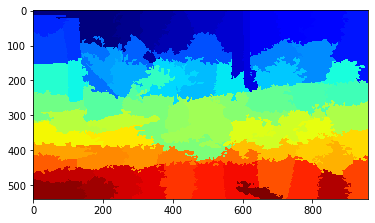

In [20]:
plt.imshow(slic(patos1_filtro,n_segments=90),cmap="jet")

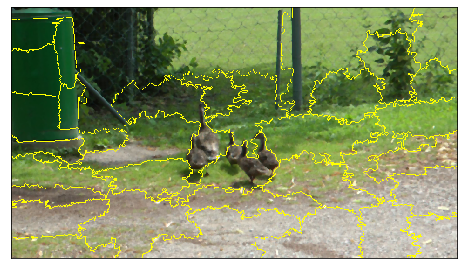

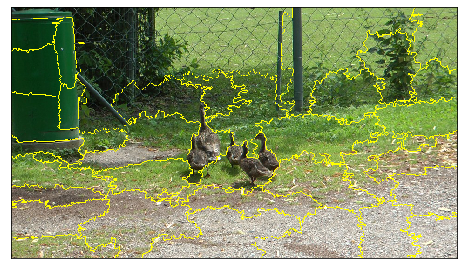

In [21]:
imshow(mark_boundaries(patos1_filtro,slic(patos,n_segments=74)))
imshow(mark_boundaries(patos1,slic(patos,n_segments=74)))

### Segmentacion Felzenswalb

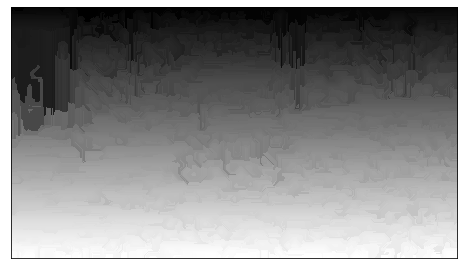

7612

In [22]:
#segmentacion felzenszwalb
segmentacionFels= felzenszwalb(patos1,multichannel=True,sigma=7)
imshow(segmentacionFels)
len(np.unique(segmentacionFels))

Hace el proceso de mark boundaries, utilizando la imagen original y 
la segmentacion Felzenszwalb

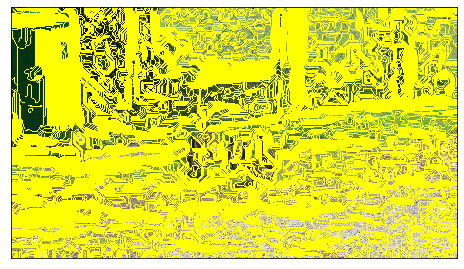

In [23]:
imshow(mark_boundaries(patos1,segmentacionFels))

#### QuickSegmentation

__Advertencia!!__ Este proceso toma mucho tiempo. cerca de 120segundos

Se genera una segmentacion rapida, usando la imagen origina, y se muestra el resultado en chroma JET

In [24]:
quickSegmentation = quickshift(patos1, kernel_size=20, max_dist=5)#20.5

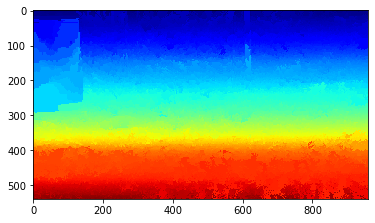

In [25]:
plt.imshow(quickSegmentation,cmap="jet")

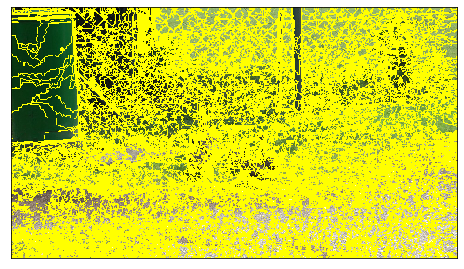

In [26]:
imshow(mark_boundaries(patos1, quickSegmentation))

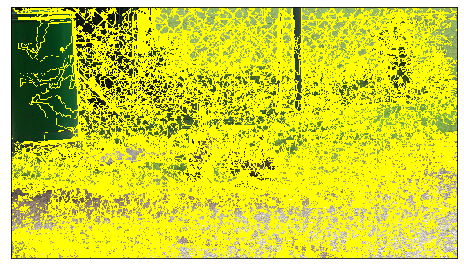

In [27]:
#Limpiar bordes
imshow(mark_boundaries(patos1, clear_border(quickSegmentation)))

Se puede notar que este proceso no es muy efectivo, ya que sigue considerando todos los detalles de la imagen para crear separaciones.

## Active contour model
Este proceso, es semi supervisado, pues requiere que el usuario meta coordenadas dentro de la imagen para poder analizar cierta zona


In [28]:
img = patos1_filtro
img = rgb2gray(img)
#img=mark_boundaries(patos,slic(patos,n_segments=74))
s = np.linspace(0, 2*np.pi, 600) #El 3er dato va para la linea azul, que tanto s epuede expandir
r = 300 + 100*np.sin(s) #EJEY + radio
c = 470 + 130*np.cos(s) # EJEX + radio
init = np.array([r, c]).T


Se hace un "snake", que seria el que va a cubrir a la objetivo dentro del area seleccionada. 
Esto se realiza con un active_contour, aplicando un filtro gausiano para que el contorno no se desvie con detalles dentro de la imagen

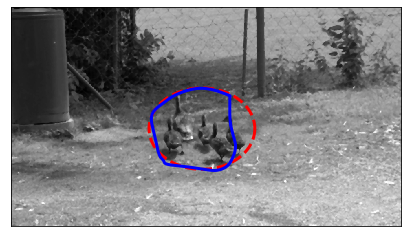

In [29]:
snake = active_contour(gaussian(img, 2),
                       init,
                       alpha=0.015, beta=10, gamma=0.011)#, #gamm es la tolerancia?
#                       coordinates='rc')
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

plt.show()

A pesar que es una buena tecnica, en esta imagen, tiene demasiados detalles y colores similares entre el objetivo y parte del fondo

## Segmentacion por watershed, y gradiente


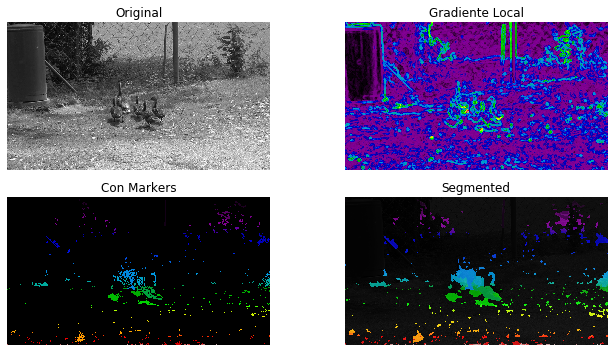

In [30]:
patos2 = data.imread('img/ducks01_0100.jpg')
im = cv2.cvtColor(patos2, cv2.COLOR_BGR2GRAY)
image = img_as_ubyte(im)
#Quitar el ruido , con median
denoised = rank.median(image, disk(4))

# Gradiente local, encontrar una region continue
gradient = rank.gradient(denoised, disk(4))

#Colocar marcadores dentro de la imagen sin ruido, y con gradiente
markers = rank.gradient(denoised, disk(1)) < 10
markers = ndi.label(markers)[0]

# Procesar el watershed
labels = watershed(gradient, markers)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title("Original")

ax[1].imshow(gradient, cmap=plt.cm.nipy_spectral)
ax[1].set_title("Gradiente Local")

ax[2].imshow(markers, cmap=plt.cm.nipy_spectral)
ax[2].set_title("Con Markers")

ax[3].imshow(image, cmap=plt.cm.gray)
ax[3].imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.9)
ax[3].set_title("Segmented")

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

Este metodo logra identificar de una mejor manera el objetivo. Aunque carece de precision al encontrar bordes delimiatentes.
Aparte se encuentra demasiado ruido. por desgracia, aplicar un filtro gausiano reduce considerablemente el resultado

## Ubicacion de bordes
Se utiliza unicamente el feature canny, a una imagen con filtro gausiano

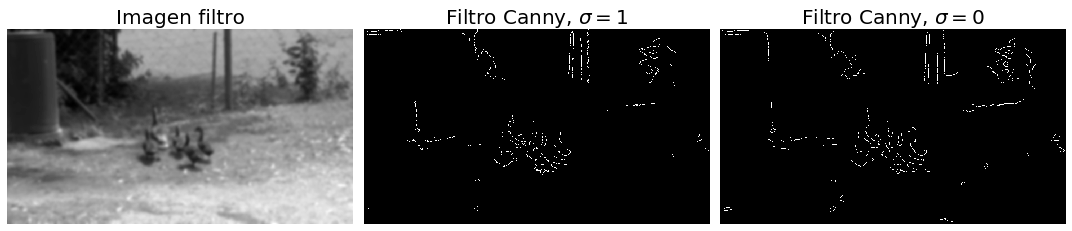

In [31]:
#im2=im.copy()
im2=patos1_filtro
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
im2 = ndi.gaussian_filter(im2, 3.5)
im2 += (0.2 * np.random.random(im.shape)).astype("uint8")

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im2)
edges2 = feature.canny(im2, sigma=0)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 10),
                                    sharex=True, sharey=True)

ax1.imshow(im2, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('Imagen filtro', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Filtro Canny, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Filtro Canny, $\sigma=0$', fontsize=20)

fig.tight_layout()

plt.show()

Este proceso (igual que el de watershed) identifica los bordes del objetivo de una manera sencilla.
aunque pierde mucho detalle y se pierde la forma de los patos

## Active Contour
Se realizara otro contorno, pero usando las tecnicas morfologicas GAC y ACWE


In [32]:

def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """
    def _store(x):
        lst.append(np.copy(x))
    return _store



### Controno Morfologico ACWE

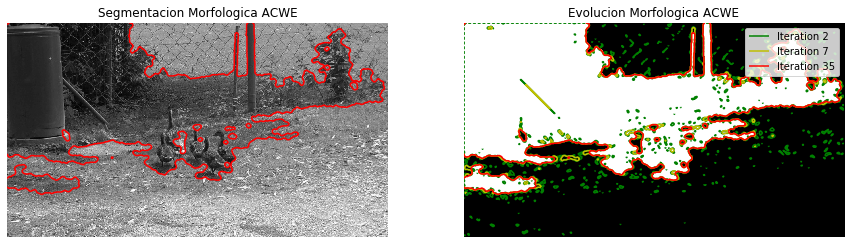

In [33]:
image = img_as_float(patos2D)

# Initial level set
init_ls = checkerboard_level_set(image.shape, 6) #Los puntos verdes

# la lista evolution, almacena cada iteracion de la evolucion.
evolution = []
callback = store_evolution_in(evolution)
ls = morphological_chan_vese(image, 35, init_level_set=init_ls, smoothing=3,
                             iter_callback=callback)

fig, axes = plt.subplots(1,2, figsize=(15, 15))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title("Segmentacion Morfologica ACWE", fontsize=12)

ax[1].imshow(ls, cmap="gray")
ax[1].set_axis_off()
contour = ax[1].contour(evolution[2], [0.5], colors='g')
contour.collections[0].set_label("Iteration 2")
contour = ax[1].contour(evolution[7], [0.5], colors='y')
contour.collections[0].set_label("Iteration 7")
contour = ax[1].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 35")
ax[1].legend(loc="upper right")
title = "Evolucion Morfologica ACWE"
ax[1].set_title(title, fontsize=12)
comparar_resultado=ls

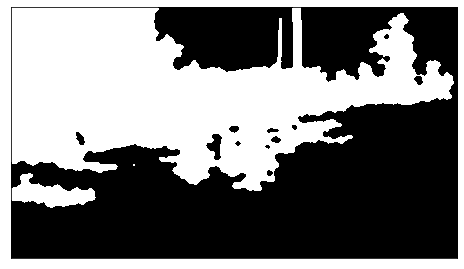

0.091465890190292


In [34]:
imshow(comparar_resultado)
print(factor_f_evaluation(comparar_resultado, gt_patos))

### Contorno Morfologico GAC

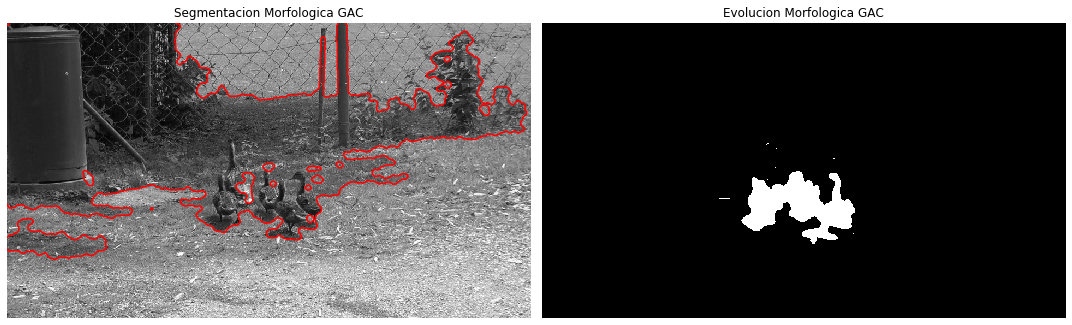

In [35]:

image = img_as_float(patos2D)
gimage = inverse_gaussian_gradient(image)

# Ajustes de LevelSet, recorte o enfoque de un area especifica
init_ls = np.zeros(image.shape, dtype=np.int8)
init_ls[220:-120, 320:-380] = 1
# la lista evolution, almacena cada iteracion de la evolucion.
evolution = []
callback = store_evolution_in(evolution)
ls2 = morphological_geodesic_active_contour(gimage, 1000, init_ls,
                                           smoothing=1, balloon=-1,
                                           threshold=0.78,
                                           iter_callback=callback)

fig, axes = plt.subplots(1,2, figsize=(15, 15))
ax = axes.flatten()
ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title("Segmentacion Morfologica GAC", fontsize=12)

ax[1].imshow(ls2, cmap="gray")
ax[1].set_axis_off()
title = "Evolucion Morfologica GAC"
ax[1].set_title(title, fontsize=12)

fig.tight_layout()
plt.show()
comparar_resultado=ls2

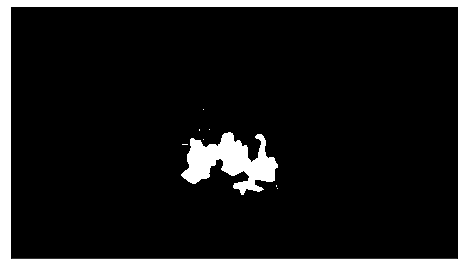

0.685841052385771


In [36]:

comparar_resultado=ls2
imshow(comparar_resultado)
print(factor_f_evaluation(comparar_resultado, gt_patos))

La mayor ventaja de la Evolucion Morfologica GAC, es que se puede delimitar, 
ajustar la evolucion y el threshold

## Watershed
Se realiza previamente un filtrado sobel para ir delimitando bordes(mapa de elevacion).
Seguido de la creacion de marcadores, se cambian los valores dentro de un umbral, haciendo un contraste alto
Finalmente se aplica el Watershed con el mapa de elevacion y los marcadores
Al resultado se realiza una inversion binaria con llenado de agujeros

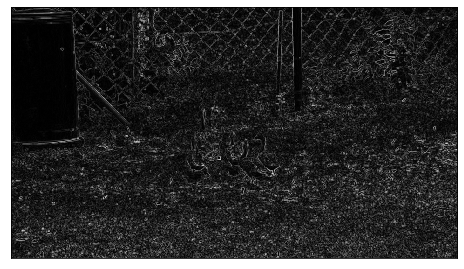

In [37]:
elevation_map=sobel(patos2D)
imshow(elevation_map)

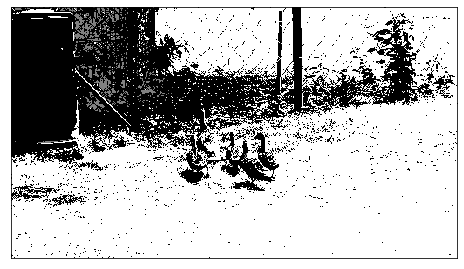

In [38]:
markers = np.zeros_like(patos2D)
markers[patos2D <20] = 1
markers[patos2D >90]=2
imshow(markers)

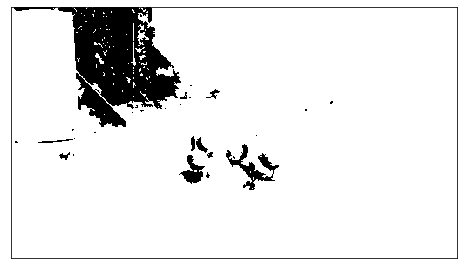

In [39]:
segmentation = watershed(elevation_map, markers)
imshow(segmentation)

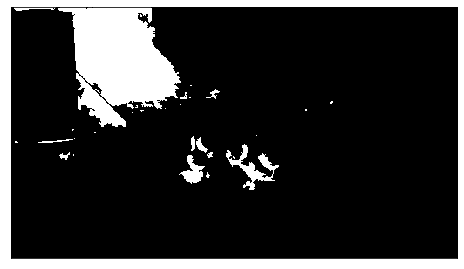

In [40]:
#remove small holes and invert binary
segmentation = ndi.binary_fill_holes(segmentation -2 )
imshow(segmentation)

In [41]:
print(factor_f_evaluation(segmentation, gt_patos))

0.12820768846729905


Se puede aprecia que este metodo, encuentra al objetivo, pero le hace una gran erosion.
Tambien que abarca un objeto distinto como el objetivo.